In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SequentialFeatureSelector
#from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
train_df = pd.read_csv('train.csv')
train_df.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [3]:
print("Number of rows in training dataset:", len(train_df))

Number of rows in training dataset: 75757


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [5]:
train_df.describe()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
count,75757.000000,7.575700e+04,73920.000000,49048.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,...,75757.000000,75757.000000,75757.000000,75757.000000,34675.000000,33946.000000,34675.000000,29961.000000,75757.000000,75757.000000
mean,4.367755,1.659839e+05,1952.306764,61.048605,39.506323,11.432343,34.310468,59.054952,11.720567,35.526837,...,82.709809,14.058701,0.279539,0.002442,66.552675,62.779974,4.190601,109.142051,82.584693,37878.000000
std,1.471441,2.468758e+05,37.053619,28.663683,60.656596,9.381027,6.996108,5.355458,12.577272,8.866697,...,25.282913,10.943996,2.252323,0.142140,131.147834,130.308106,6.458789,50.699751,58.255403,21869.306509
min,1.000000,9.430000e+02,0.000000,0.000000,-6.400000,-19.000000,10.806452,42.000000,-13.000000,13.250000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,12.000000,1.001169,0.000000
25%,3.000000,6.237900e+04,1927.000000,40.000000,11.900000,6.000000,29.827586,56.000000,2.000000,31.625000,...,72.000000,6.000000,0.000000,0.000000,1.000000,1.000000,1.000000,88.000000,54.528601,18939.000000
50%,5.000000,9.136700e+04,1951.000000,67.000000,25.000000,11.000000,34.451613,59.000000,9.000000,34.107143,...,84.000000,12.000000,0.000000,0.000000,1.000000,1.000000,1.000000,104.000000,75.293716,37878.000000
75%,6.000000,1.660000e+05,1977.000000,85.000000,42.700000,13.000000,37.322581,62.000000,20.000000,40.879310,...,97.000000,17.000000,0.000000,0.000000,1.000000,1.000000,1.000000,131.000000,97.277534,56817.000000
max,6.000000,6.385382e+06,2015.000000,100.000000,1924.500000,49.000000,64.758065,91.000000,48.000000,65.107143,...,260.000000,185.000000,119.000000,16.000000,360.000000,360.000000,23.300000,311.000000,997.866120,75756.000000


In [6]:
test_df = pd.read_csv('test.csv')
test_df.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75757
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75758
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75759
3,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75760
4,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,...,0,29,5,2,0,340.0,330.0,22.8,126.0,75761


In [7]:
print("Number of rows in test dataset:", len(test_df))

Number of rows in test dataset: 9705


In [8]:
df_with_numeric_features = train_df.select_dtypes(exclude=['object'])
print("Numeric features:")
for col in df_with_numeric_features:
    print(f"{col}")

Numeric features:
Year_Factor
floor_area
year_built
energy_star_rating
ELEVATION
january_min_temp
january_avg_temp
january_max_temp
february_min_temp
february_avg_temp
february_max_temp
march_min_temp
march_avg_temp
march_max_temp
april_min_temp
april_avg_temp
april_max_temp
may_min_temp
may_avg_temp
may_max_temp
june_min_temp
june_avg_temp
june_max_temp
july_min_temp
july_avg_temp
july_max_temp
august_min_temp
august_avg_temp
august_max_temp
september_min_temp
september_avg_temp
september_max_temp
october_min_temp
october_avg_temp
october_max_temp
november_min_temp
november_avg_temp
november_max_temp
december_min_temp
december_avg_temp
december_max_temp
cooling_degree_days
heating_degree_days
precipitation_inches
snowfall_inches
snowdepth_inches
avg_temp
days_below_30F
days_below_20F
days_below_10F
days_below_0F
days_above_80F
days_above_90F
days_above_100F
days_above_110F
direction_max_wind_speed
direction_peak_wind_speed
max_wind_speed
days_with_fog
site_eui
id


In [9]:
df_with_non_numeric_features = train_df.select_dtypes(include=['object'])
print("Non-numeric columns:")
for col in df_with_non_numeric_features:
    print(f"{col}")

Non-numeric columns:
State_Factor
building_class
facility_type


In [10]:
column_names = train_df.columns.tolist()
column_names

['Year_Factor',
 'State_Factor',
 'building_class',
 'facility_type',
 'floor_area',
 'year_built',
 'energy_star_rating',
 'ELEVATION',
 'january_min_temp',
 'january_avg_temp',
 'january_max_temp',
 'february_min_temp',
 'february_avg_temp',
 'february_max_temp',
 'march_min_temp',
 'march_avg_temp',
 'march_max_temp',
 'april_min_temp',
 'april_avg_temp',
 'april_max_temp',
 'may_min_temp',
 'may_avg_temp',
 'may_max_temp',
 'june_min_temp',
 'june_avg_temp',
 'june_max_temp',
 'july_min_temp',
 'july_avg_temp',
 'july_max_temp',
 'august_min_temp',
 'august_avg_temp',
 'august_max_temp',
 'september_min_temp',
 'september_avg_temp',
 'september_max_temp',
 'october_min_temp',
 'october_avg_temp',
 'october_max_temp',
 'november_min_temp',
 'november_avg_temp',
 'november_max_temp',
 'december_min_temp',
 'december_avg_temp',
 'december_max_temp',
 'cooling_degree_days',
 'heating_degree_days',
 'precipitation_inches',
 'snowfall_inches',
 'snowdepth_inches',
 'avg_temp',
 'days_bel

In [11]:
column_names.remove('id')

train_df.drop_duplicates(subset=column_names, keep='last', inplace=True)
print("Number of rows after removing duplicates", len(train_df))

Number of rows after removing duplicates 75718


In [12]:
df_with_non_numeric_features.columns

Index(['State_Factor', 'building_class', 'facility_type'], dtype='object')

In [13]:
train_df['facility_type'].value_counts()

Multifamily_Uncategorized                    39430
Office_Uncategorized                         12508
Education_Other_classroom                     3860
Lodging_Hotel                                 2098
2to4_Unit_Building                            1893
Commercial_Other                              1744
5plus_Unit_Building                           1273
Warehouse_Nonrefrigerated                     1255
Retail_Uncategorized                          1130
Education_College_or_university               1053
Nursing_Home                                   772
Education_Uncategorized                        704
Mixed_Use_Commercial_and_Residential           672
Lodging_Dormitory_or_fraternity_sorority       669
Warehouse_Distribution_or_Shipping_center      604
Warehouse_Selfstorage                          577
Grocery_store_or_food_market                   448
Office_Medical_non_diagnostic                  447
Health_Care_Inpatient                          407
Religious_worship              

In [14]:
train_df['facility_type'] = train_df['facility_type'].str.lower()
train_df['facility_type'].value_counts()

multifamily_uncategorized                    39430
office_uncategorized                         12508
education_other_classroom                     3860
lodging_hotel                                 2098
2to4_unit_building                            1893
commercial_other                              1744
5plus_unit_building                           1273
warehouse_nonrefrigerated                     1255
retail_uncategorized                          1130
education_college_or_university               1053
nursing_home                                   772
education_uncategorized                        704
mixed_use_commercial_and_residential           672
lodging_dormitory_or_fraternity_sorority       669
warehouse_distribution_or_shipping_center      604
warehouse_selfstorage                          577
grocery_store_or_food_market                   448
office_medical_non_diagnostic                  447
health_care_inpatient                          407
religious_worship              

In [15]:
train_df['precipitation_inches'].describe()

count    75718.000000
mean        42.431848
std         10.589174
min          0.000000
25%         39.350000
50%         42.170000
75%         46.320000
max        107.690000
Name: precipitation_inches, dtype: float64

In [16]:
train_df['energy_star_rating'].describe()

count    49036.000000
mean        61.049168
std         28.664237
min          0.000000
25%         40.000000
50%         67.000000
75%         85.000000
max        100.000000
Name: energy_star_rating, dtype: float64

In [17]:
train_df['days_below_30F'].describe()

count    75718.000000
mean        48.764006
std         27.588600
min          0.000000
25%         22.000000
50%         50.000000
75%         66.000000
max        170.000000
Name: days_below_30F, dtype: float64

In [18]:
train_df['days_above_80F'].describe()

count    75718.000000
mean        82.708616
std         25.283873
min          0.000000
25%         72.000000
50%         84.000000
75%         97.000000
max        260.000000
Name: days_above_80F, dtype: float64

In [19]:
features_considered = ['Year_Factor','floor_area','year_built','energy_star_rating','ELEVATION',\
                       'january_avg_temp','february_avg_temp','march_avg_temp','april_avg_temp',\
                       'may_avg_temp','june_avg_temp','july_avg_temp','august_avg_temp',\
                       'september_avg_temp','october_avg_temp','november_avg_temp','december_avg_temp',\
                       'cooling_degree_days','heating_degree_days','precipitation_inches',\
                       'snowfall_inches','snowdepth_inches','avg_temp','days_below_30F',\
                       'days_above_80F','site_eui']
# calculate z-scores for numeric features
z_scores = zscore(train_df[features_considered], nan_policy='omit')
z_scores

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_avg_temp,february_avg_temp,march_avg_temp,april_avg_temp,may_avg_temp,...,december_avg_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_above_80F,site_eui
0,-2.289710,-0.425593,-0.278180,-1.746067,-0.612556,2.314339,1.698936,1.385976,0.686313,-2.465680,...,1.303282,-2.776088,-1.656242,-2.440419,-1.636154,-0.940724,0.355399,-1.767554,-2.717506,2.854924
1,-2.289710,0.440620,0.072633,-0.559908,-0.622465,2.314339,1.698936,1.385976,0.686313,-2.465680,...,1.303282,-2.776088,-1.656242,-2.440419,-1.636154,-0.940724,0.355399,-1.767554,-2.717506,-0.963617
2,-2.289710,0.465150,-0.035309,1.254218,-0.622465,2.314339,1.698936,1.385976,0.686313,-2.465680,...,1.303282,-2.776088,-1.656242,-2.440419,-1.636154,-0.940724,0.355399,-1.767554,-2.717506,-0.994665
3,-2.289710,-0.449684,0.747274,-0.525021,-0.622465,2.314339,1.698936,1.385976,0.686313,-2.465680,...,1.303282,-2.776088,-1.656242,-2.440419,-1.636154,-0.940724,0.355399,-1.767554,-2.717506,-0.587116
4,-2.289710,-0.406222,0.882202,1.358879,-0.612556,2.314339,1.698936,1.385976,0.686313,-2.465680,...,1.303282,-2.776088,-1.656242,-2.440419,-1.636154,-0.940724,0.355399,-1.767554,-2.717506,-1.352045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,1.109106,-0.591835,1.152058,-1.850728,-0.047764,1.306833,1.369975,0.734201,0.992969,-1.628386,...,-0.526893,-2.405838,-0.671114,0.245361,-1.557547,-0.935019,-0.458785,-1.550071,-2.282443,0.865341
75753,1.109106,-0.510086,-1.141719,1.289105,-0.047764,1.306833,1.369975,0.734201,0.992969,-1.628386,...,-0.526893,-2.405838,-0.671114,0.245361,-1.557547,-0.935019,-0.458785,-1.550071,-2.282443,-0.740476
75754,1.109106,-0.560640,-0.952820,NaN,-0.047764,0.329298,0.689414,-0.470009,-1.440280,-4.151817,...,-1.922882,-2.929295,2.296403,6.033386,0.418868,1.558203,-3.687011,-0.825129,-3.033915,-0.587160
75755,1.109106,-0.456808,1.610813,NaN,-0.047764,0.329298,0.689414,-0.470009,-1.440280,-4.151817,...,-1.922882,-2.929295,2.296403,6.033386,0.418868,1.558203,-3.687011,-0.825129,-3.033915,8.755743


In [20]:
# convert to absolute values
abs_z_scores = np.abs(z_scores)
# filter based on |z-score| less than 3
filtered_entries = (abs_z_scores < 3).all(axis=1) | train_df['Year_Factor'].isna()
filtered_entries

0        False
1        False
2        False
3        False
4        False
         ...  
75752     True
75753     True
75754    False
75755    False
75756    False
Length: 75718, dtype: bool

In [21]:
print("Outliers present in the dataset")
train_df.loc[filtered_entries == False]

Outliers present in the dataset


,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.500000,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,warehouse_distribution_or_shipping_center,274000.0,1955.0,45.0,1.8,36,50.500000,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,retail_enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.500000,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,education_other_classroom,55325.0,1980.0,46.0,1.8,36,50.500000,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,warehouse_nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.500000,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75749,6,State_11,Commercial,commercial_other,47237.0,1948.0,NaN,63.1,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,126.285151,75749
75750,6,State_11,Commercial,commercial_other,72000.0,2013.0,NaN,63.1,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,40.525884,75750
75754,6,State_11,Commercial,commercial_other,28072.0,1917.0,NaN,36.6,26,36.612903,...,6,0,0,0,NaN,NaN,NaN,NaN,48.404398,75754
75755,6,State_11,Commercial,commercial_other,53575.0,2012.0,NaN,36.6,26,36.612903,...,6,0,0,0,NaN,NaN,NaN,NaN,592.022750,75755


In [22]:
df_without_outliers = train_df[filtered_entries]
print('Number of rows after filtering outliers:', len(df_without_outliers))
df_without_outliers.head()
train_df = df_without_outliers.copy(deep = True)

Number of rows after filtering outliers: 42811


In [23]:
#Find columns which have missing values
train_df.isna().sum()[train_df.isna().sum()>0]

direction_max_wind_speed     22217
direction_peak_wind_speed    22765
max_wind_speed               22217
days_with_fog                26263
dtype: int64

In [24]:
#Delete columns that have missing values
train_df = train_df.drop(columns=['id'])

In [25]:
#Fill in missing spots using specific values
#train_df['year_built']=train_df['year_built'].fillna(train_df['year_built'].mean())
train_df['energy_star_rating']=train_df['energy_star_rating'].fillna(train_df['energy_star_rating'].mean())
train_df['direction_max_wind_speed']=train_df['direction_max_wind_speed'].fillna(train_df['direction_max_wind_speed'].mean())
train_df['direction_peak_wind_speed']=train_df['direction_peak_wind_speed'].fillna(train_df['direction_peak_wind_speed'].mean())
train_df['max_wind_speed']=train_df['max_wind_speed'].fillna(train_df['max_wind_speed'].mean())
train_df['days_with_fog']=train_df['days_with_fog'].fillna(train_df['days_with_fog'].mean())
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42811 entries, 404 to 75753
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                42811 non-null  int64  
 1   State_Factor               42811 non-null  object 
 2   building_class             42811 non-null  object 
 3   facility_type              42811 non-null  object 
 4   floor_area                 42811 non-null  float64
 5   year_built                 42811 non-null  float64
 6   energy_star_rating         42811 non-null  float64
 7   ELEVATION                  42811 non-null  float64
 8   january_min_temp           42811 non-null  int64  
 9   january_avg_temp           42811 non-null  float64
 10  january_max_temp           42811 non-null  int64  
 11  february_min_temp          42811 non-null  int64  
 12  february_avg_temp          42811 non-null  float64
 13  february_max_temp          42811 non-null  i

In [26]:
print("Number of rows in training data after filtering missing values:", len(train_df))
train_df.head()

Number of rows in training data after filtering missing values: 42811


,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui
404,2,State_1,Residential,mixed_use_predominantly_commercial,34173.0,1913.0,100.0,2.4,27,48.951613,...,0,113,35,1,0,1.0,1.0,1.0,88.0,18.674253
405,2,State_1,Commercial,lodging_hotel,46800.0,1914.0,61.0,2.4,27,48.951613,...,0,113,35,1,0,1.0,1.0,1.0,88.0,91.140820
406,2,State_1,Commercial,lodging_hotel,162214.0,1924.0,35.0,2.4,27,48.951613,...,0,113,35,1,0,1.0,1.0,1.0,88.0,106.120497
407,2,State_1,Commercial,lodging_hotel,168000.0,1927.0,74.0,2.4,27,48.951613,...,0,113,35,1,0,1.0,1.0,1.0,88.0,65.825098
411,2,State_1,Commercial,lodging_hotel,99000.0,1929.0,98.0,2.4,27,48.951613,...,0,113,35,1,0,1.0,1.0,1.0,88.0,54.411775


In [27]:
# do the same for test_df
test_df.isna().sum()[test_df.isna().sum()>0]

year_built                     92
energy_star_rating           2254
direction_max_wind_speed     8575
direction_peak_wind_speed    8575
max_wind_speed               8575
days_with_fog                9117
dtype: int64

In [28]:
#Fill in missing spots using specific values
test_df['year_built']=test_df['year_built'].fillna(test_df['year_built'].mean())
test_df['energy_star_rating']=test_df['energy_star_rating'].fillna(test_df['energy_star_rating'].mean())
test_df['direction_max_wind_speed']=test_df['direction_max_wind_speed'].fillna(test_df['direction_max_wind_speed'].mean())
test_df['direction_peak_wind_speed']=test_df['direction_peak_wind_speed'].fillna(test_df['direction_peak_wind_speed'].mean())
test_df['max_wind_speed']=test_df['max_wind_speed'].fillna(test_df['max_wind_speed'].mean())
test_df['days_with_fog']=test_df['days_with_fog'].fillna(test_df['days_with_fog'].mean())
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9705 entries, 0 to 9704
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                9705 non-null   int64  
 1   State_Factor               9705 non-null   object 
 2   building_class             9705 non-null   object 
 3   facility_type              9705 non-null   object 
 4   floor_area                 9705 non-null   float64
 5   year_built                 9705 non-null   float64
 6   energy_star_rating         9705 non-null   float64
 7   ELEVATION                  9705 non-null   float64
 8   january_min_temp           9705 non-null   int64  
 9   january_avg_temp           9705 non-null   float64
 10  january_max_temp           9705 non-null   int64  
 11  february_min_temp          9705 non-null   int64  
 12  february_avg_temp          9705 non-null   float64
 13  february_max_temp          9705 non-null   int64

In [29]:
#Delete columns that have missing values
test_df = test_df.drop(columns=['id'])

In [30]:
print("Number of rows in testing data after filtering missing values:", len(test_df))
test_df.head()

Number of rows in testing data after filtering missing values: 9705


,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,...,0,0,29,5,2,0,321.743363,310.19469,18.131327,150.755102
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,...,0,0,29,5,2,0,321.743363,310.19469,18.131327,150.755102
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,...,0,0,29,5,2,0,321.743363,310.19469,18.131327,150.755102
3,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,...,0,0,29,5,2,0,321.743363,310.19469,18.131327,150.755102
4,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,...,0,0,29,5,2,0,340.000000,330.00000,22.800000,126.000000


<AxesSubplot:>

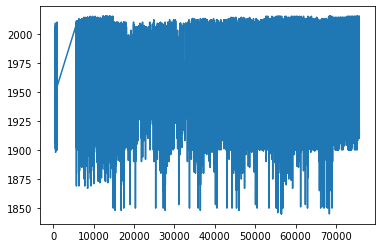

In [31]:
train_df.year_built.plot()

In [32]:
numeric_features = train_df.select_dtypes(exclude=['object']).columns.tolist()
numeric_features.remove('site_eui')
cor_matrix = train_df[numeric_features + ['site_eui']].corr()
cor_matrix

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui
Year_Factor,1.000000,-0.106583,0.091911,0.006274,0.119041,0.164611,0.098326,-0.162898,-0.337544,0.060446,...,0.201770,0.143492,0.211486,-0.549312,NaN,0.108636,0.100058,0.107486,0.493796,-0.093706
floor_area,-0.106583,1.000000,0.147694,0.016849,0.146837,-0.177844,-0.155561,-0.087756,-0.100730,-0.122705,...,0.124404,0.111366,0.133685,0.065186,NaN,-0.006368,-0.009495,-0.007321,-0.043387,0.061453
year_built,0.091911,0.147694,1.000000,-0.085856,0.046442,0.102210,0.083685,-0.019026,0.119514,0.080688,...,0.042202,-0.097958,0.026139,-0.060997,NaN,-0.009751,-0.020014,-0.006789,0.055977,-0.053531
energy_star_rating,0.006274,0.016849,-0.085856,1.000000,-0.034694,0.120750,0.123730,0.043188,0.093515,0.107440,...,-0.027860,-0.061339,0.010048,0.043363,NaN,-0.000939,0.000621,-0.000484,0.004072,-0.620362
ELEVATION,0.119041,0.146837,0.046442,-0.034694,1.000000,-0.453157,-0.410511,-0.578149,-0.194806,-0.246736,...,0.746370,0.072578,0.330586,-0.043003,NaN,0.015597,0.030503,0.009487,0.296089,0.034054
january_min_temp,0.164611,-0.177844,0.102210,0.120750,-0.453157,1.000000,0.968242,0.489813,0.725043,0.783737,...,-0.437576,-0.579587,-0.251743,0.045484,NaN,-0.037776,-0.039600,-0.038427,0.067950,-0.291522
january_avg_temp,0.098326,-0.155561,0.083685,0.123730,-0.410511,0.968242,1.000000,0.584322,0.713088,0.862203,...,-0.381190,-0.580944,-0.195932,0.076582,NaN,-0.118769,-0.114097,-0.118595,0.040012,-0.275864
january_max_temp,-0.162898,-0.087756,-0.019026,0.043188,-0.578149,0.489813,0.584322,1.000000,0.412154,0.597447,...,-0.583759,-0.192801,-0.082145,-0.017517,NaN,-0.162471,-0.152566,-0.161997,-0.139032,-0.088754
february_min_temp,-0.337544,-0.100730,0.119514,0.093515,-0.194806,0.725043,0.713088,0.412154,1.000000,0.689874,...,-0.375565,-0.770435,-0.332522,0.200727,NaN,-0.155731,-0.148391,-0.154896,-0.077658,-0.259117
february_avg_temp,0.060446,-0.122705,0.080688,0.107440,-0.246736,0.783737,0.862203,0.597447,0.689874,1.000000,...,-0.318382,-0.605749,-0.072227,0.157819,NaN,-0.424753,-0.404956,-0.421111,-0.028416,-0.246848


<AxesSubplot:>

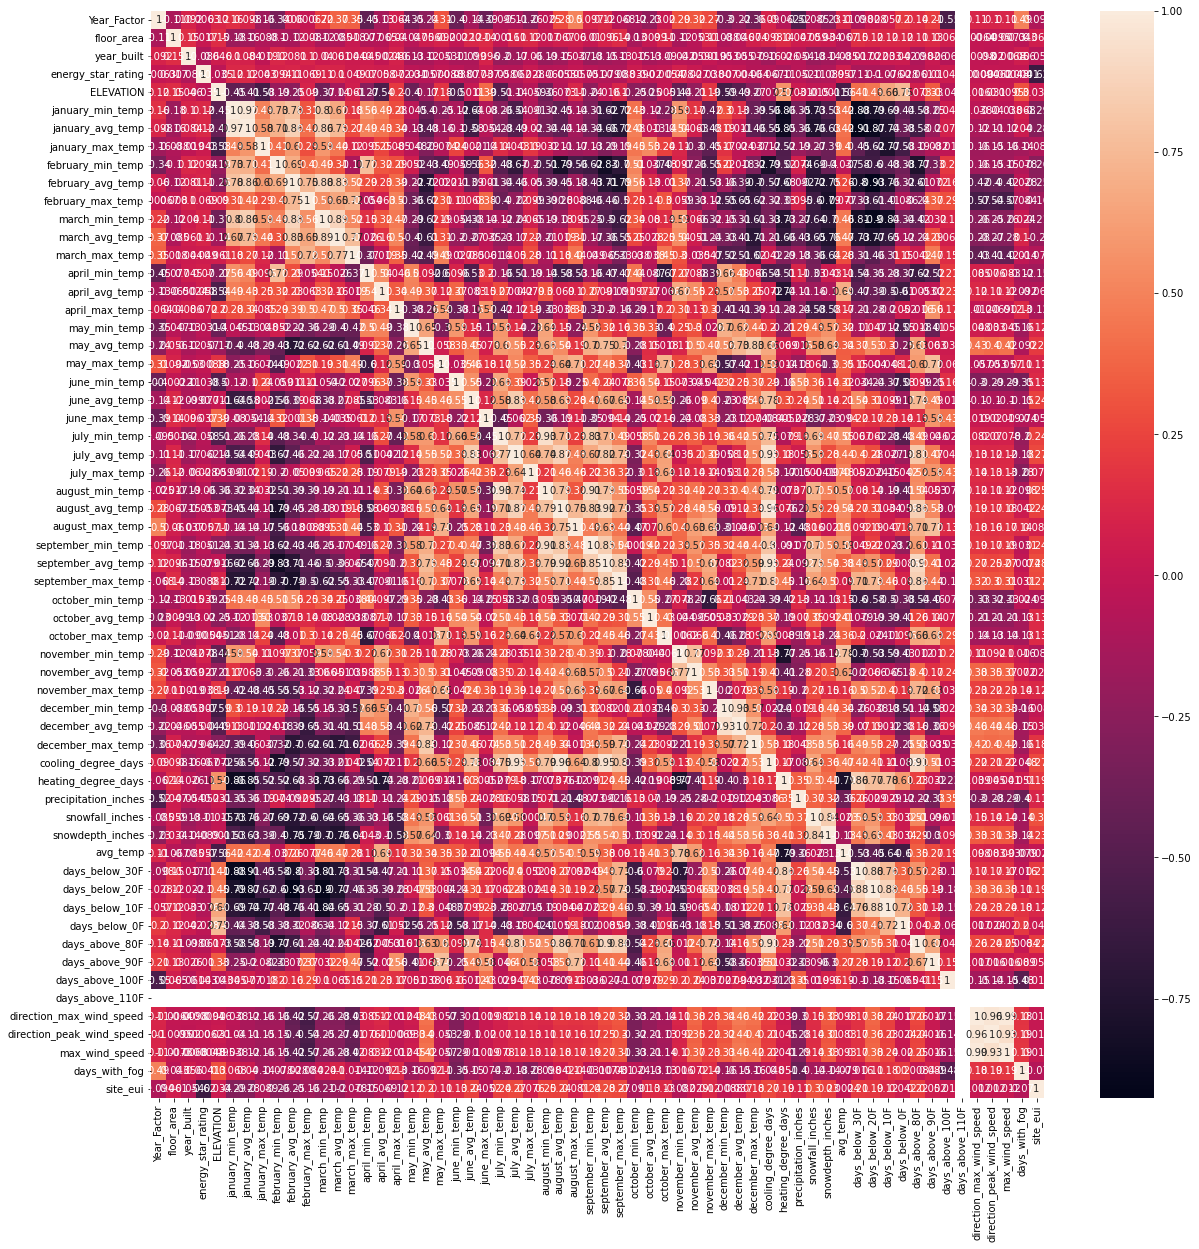

In [33]:
plt.figure(figsize = (20,20))
sns.heatmap(cor_matrix, annot = True)

In [34]:
cor_matrix['site_eui'].abs() > 0.2

Year_Factor                  False
floor_area                   False
year_built                   False
energy_star_rating            True
ELEVATION                    False
january_min_temp              True
january_avg_temp              True
january_max_temp             False
february_min_temp             True
february_avg_temp             True
february_max_temp            False
march_min_temp                True
march_avg_temp               False
march_max_temp               False
april_min_temp               False
april_avg_temp               False
april_max_temp               False
may_min_temp                 False
may_avg_temp                  True
may_max_temp                 False
june_min_temp                False
june_avg_temp                 True
june_max_temp                False
july_min_temp                 True
july_avg_temp                 True
july_max_temp                False
august_min_temp               True
august_avg_temp               True
august_max_temp     

In [35]:
features_with_higher_cor_to_target = cor_matrix['site_eui'][cor_matrix['site_eui'].abs() > 0.2].index.tolist()
features_with_higher_cor_to_target.remove('site_eui')
print("Features selected ", features_with_higher_cor_to_target)

Features selected  ['energy_star_rating', 'january_min_temp', 'january_avg_temp', 'february_min_temp', 'february_avg_temp', 'march_min_temp', 'may_avg_temp', 'june_avg_temp', 'july_min_temp', 'july_avg_temp', 'august_min_temp', 'august_avg_temp', 'september_min_temp', 'september_avg_temp', 'september_max_temp', 'cooling_degree_days', 'snowfall_inches', 'snowdepth_inches', 'days_below_30F', 'days_above_80F']


In [36]:
# Mutual Info Regression
numeric_features = np.array(numeric_features)
m_info = mutual_info_regression(train_df[numeric_features], train_df['site_eui'], \
                                discrete_features=[0, 3, 4, 6], n_neighbors=5)
features_with_higher_mutual_info = numeric_features[m_info>0.2]
print("Features selected ", features_with_higher_mutual_info)

Features selected  ['Year_Factor' 'energy_star_rating' 'january_min_temp' 'january_avg_temp'
 'january_max_temp' 'february_min_temp' 'february_avg_temp'
 'february_max_temp' 'march_min_temp' 'march_avg_temp' 'march_max_temp'
 'april_min_temp' 'april_avg_temp' 'april_max_temp' 'may_min_temp'
 'may_avg_temp' 'may_max_temp' 'june_min_temp' 'june_avg_temp'
 'june_max_temp' 'july_min_temp' 'july_avg_temp' 'august_min_temp'
 'august_avg_temp' 'august_max_temp' 'september_min_temp'
 'september_avg_temp' 'september_max_temp' 'october_min_temp'
 'october_avg_temp' 'october_max_temp' 'november_min_temp'
 'november_avg_temp' 'november_max_temp' 'december_min_temp'
 'december_avg_temp' 'december_max_temp' 'cooling_degree_days'
 'heating_degree_days' 'precipitation_inches' 'snowfall_inches'
 'snowdepth_inches' 'avg_temp' 'days_below_30F' 'days_below_20F'
 'days_below_10F' 'days_below_0F' 'days_above_80F' 'days_above_90F']


In [37]:
# Convert categorical variables to numerical

# grab non-numeric features
df_with_non_numeric_features = train_df.select_dtypes(include=['object'])
print("Non-numeric columns:")
for col in df_with_non_numeric_features:
    print(f"{col}")

Non-numeric columns:
State_Factor
building_class
facility_type


In [38]:
train_df['State_Factor'].value_counts()

State_6     29231
State_11     4672
State_2      3749
State_4      2675
State_8      2096
State_1       382
State_10        6
Name: State_Factor, dtype: int64

In [39]:
train_df['building_class'].value_counts()

Residential    25297
Commercial     17514
Name: building_class, dtype: int64

In [40]:
train_df['facility_type'].value_counts()

multifamily_uncategorized                    22534
office_uncategorized                          8091
education_other_classroom                     3239
2to4_unit_building                            1571
lodging_hotel                                 1453
5plus_unit_building                           1037
warehouse_nonrefrigerated                      829
nursing_home                                   613
retail_uncategorized                           579
lodging_dormitory_or_fraternity_sorority       545
warehouse_distribution_or_shipping_center      442
office_medical_non_diagnostic                  270
warehouse_uncategorized                        249
religious_worship                              245
commercial_other                               234
grocery_store_or_food_market                   170
health_care_inpatient                          149
mixed_use_commercial_and_residential           144
warehouse_refrigerated                          80
office_bank_or_other_financial 

In [41]:
# OneHotEncoding 'State_Factor'
encoder = OneHotEncoder(handle_unknown = 'ignore')
encoder.fit(np.array(train_df['State_Factor'].tolist()).reshape(-1, 1))

OneHotEncoder(handle_unknown='ignore')

In [42]:
# Create a Pandas DataFrame of the hot encoded column
transformed = encoder.transform(np.array(train_df['State_Factor'].tolist()).reshape(-1, 1)).toarray()
ohe_df_train = pd.DataFrame(transformed, columns=encoder.get_feature_names())

In [43]:
# Concat with original data
train_df.reset_index(drop=True, inplace=True)
ohe_df_train.reset_index(drop=True, inplace=True)

train_df = pd.concat([train_df, ohe_df_train], axis=1)
train_df = train_df.drop(['State_Factor'], axis=1)
train_df.head()

,Year_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,max_wind_speed,days_with_fog,site_eui,x0_State_1,x0_State_10,x0_State_11,x0_State_2,x0_State_4,x0_State_6,x0_State_8
0,2,Residential,mixed_use_predominantly_commercial,34173.0,1913.0,100.0,2.4,27,48.951613,69,...,1.0,88.0,18.674253,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Commercial,lodging_hotel,46800.0,1914.0,61.0,2.4,27,48.951613,69,...,1.0,88.0,91.140820,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Commercial,lodging_hotel,162214.0,1924.0,35.0,2.4,27,48.951613,69,...,1.0,88.0,106.120497,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,Commercial,lodging_hotel,168000.0,1927.0,74.0,2.4,27,48.951613,69,...,1.0,88.0,65.825098,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,Commercial,lodging_hotel,99000.0,1929.0,98.0,2.4,27,48.951613,69,...,1.0,88.0,54.411775,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Perform the same on test data
transformed = encoder.transform(np.array(test_df['State_Factor'].tolist()).reshape(-1, 1)).toarray()
ohe_df_test = pd.DataFrame(transformed, columns=encoder.get_feature_names())

test_df = pd.concat([test_df, ohe_df_test], axis=1)
test_df = test_df.drop(['State_Factor'], axis=1)
test_df.head()

,Year_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,direction_peak_wind_speed,max_wind_speed,days_with_fog,x0_State_1,x0_State_10,x0_State_11,x0_State_2,x0_State_4,x0_State_6,x0_State_8
0,7,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,64,...,310.19469,18.131327,150.755102,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,64,...,310.19469,18.131327,150.755102,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,64,...,310.19469,18.131327,150.755102,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,64,...,310.19469,18.131327,150.755102,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,64,...,330.00000,22.800000,126.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# Encode ordinal values

encode_categorical_values = {"Residential":0, "Commercial":1}
train_df['building_class'] = train_df['building_class'].replace(encode_categorical_values) 
train_df.head()

,Year_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,max_wind_speed,days_with_fog,site_eui,x0_State_1,x0_State_10,x0_State_11,x0_State_2,x0_State_4,x0_State_6,x0_State_8
0,2,0,mixed_use_predominantly_commercial,34173.0,1913.0,100.0,2.4,27,48.951613,69,...,1.0,88.0,18.674253,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,lodging_hotel,46800.0,1914.0,61.0,2.4,27,48.951613,69,...,1.0,88.0,91.140820,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1,lodging_hotel,162214.0,1924.0,35.0,2.4,27,48.951613,69,...,1.0,88.0,106.120497,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,1,lodging_hotel,168000.0,1927.0,74.0,2.4,27,48.951613,69,...,1.0,88.0,65.825098,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,1,lodging_hotel,99000.0,1929.0,98.0,2.4,27,48.951613,69,...,1.0,88.0,54.411775,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# Perform the same on test data
encode_categorical_values = {"Residential":0, "Commercial":1}
test_df['building_class'] = test_df['building_class'].replace(encode_categorical_values) 
test_df.head()

,Year_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,direction_peak_wind_speed,max_wind_speed,days_with_fog,x0_State_1,x0_State_10,x0_State_11,x0_State_2,x0_State_4,x0_State_6,x0_State_8
0,7,1,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,64,...,310.19469,18.131327,150.755102,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,1,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,64,...,310.19469,18.131327,150.755102,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,1,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,64,...,310.19469,18.131327,150.755102,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,1,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,64,...,310.19469,18.131327,150.755102,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,1,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,64,...,330.00000,22.800000,126.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# Log Transformation
print("Features selected ", features_with_higher_cor_to_target)

Features selected  ['energy_star_rating', 'january_min_temp', 'january_avg_temp', 'february_min_temp', 'february_avg_temp', 'march_min_temp', 'may_avg_temp', 'june_avg_temp', 'july_min_temp', 'july_avg_temp', 'august_min_temp', 'august_avg_temp', 'september_min_temp', 'september_avg_temp', 'september_max_temp', 'cooling_degree_days', 'snowfall_inches', 'snowdepth_inches', 'days_below_30F', 'days_above_80F']


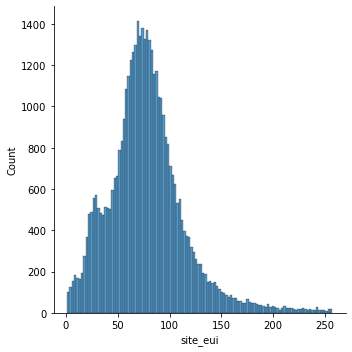

In [48]:
ax = sns.displot(train_df['site_eui'])

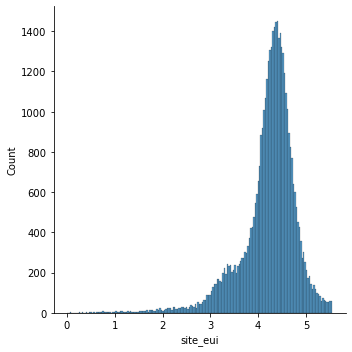

In [49]:
sns.displot(np.log(train_df.loc[train_df['site_eui']!=0, 'site_eui']))

In [50]:
# Scaling and Normalization

#Standardization (transform to mean=0, sd=1)
scaler = StandardScaler()
train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])
train_df[numeric_features].head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog
0,-2.353432,-0.793180,-1.261376,1.381623,-0.709173,2.209486,2.980034,2.801083,2.273135,2.314069,...,-0.937175,-0.345477,1.13009,2.300132,5.314371,0.0,-0.810552,-0.77493,-0.802451,-0.869161
1,-2.353432,-0.704026,-1.230498,0.016651,-0.709173,2.209486,2.980034,2.801083,2.273135,2.314069,...,-0.937175,-0.345477,1.13009,2.300132,5.314371,0.0,-0.810552,-0.77493,-0.802451,-0.869161
2,-2.353432,0.110861,-0.921714,-0.893331,-0.709173,2.209486,2.980034,2.801083,2.273135,2.314069,...,-0.937175,-0.345477,1.13009,2.300132,5.314371,0.0,-0.810552,-0.77493,-0.802451,-0.869161
3,-2.353432,0.151714,-0.829079,0.471641,-0.709173,2.209486,2.980034,2.801083,2.273135,2.314069,...,-0.937175,-0.345477,1.13009,2.300132,5.314371,0.0,-0.810552,-0.77493,-0.802451,-0.869161
4,-2.353432,-0.335465,-0.767322,1.311624,-0.709173,2.209486,2.980034,2.801083,2.273135,2.314069,...,-0.937175,-0.345477,1.13009,2.300132,5.314371,0.0,-0.810552,-0.77493,-0.802451,-0.869161


In [51]:
#Perform the same on the test data (HINT: don't refit the transform)
scaler = StandardScaler()
test_df[numeric_features] = scaler.fit_transform(test_df[numeric_features])
test_df[numeric_features].head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog
0,0.0,-0.513332,0.757692,-1.132239,-0.765952,1.964985,1.99747,0.679483,1.871769,2.323864,...,-0.804544,-0.599846,-1.222555,-0.530789,2.906863,0.0,-8.713015e-15,0.000000,-2.090200e-14,-1.966722e-15
1,0.0,-0.538395,-0.054638,-0.396831,-0.602438,1.964985,1.99747,0.679483,1.871769,2.323864,...,-0.804544,-0.599846,-1.222555,-0.530789,2.906863,0.0,-8.713015e-15,0.000000,-2.090200e-14,-1.966722e-15
2,0.0,-0.560371,-0.325414,-2.603054,-0.551836,1.964985,1.99747,0.679483,1.871769,2.323864,...,-0.804544,-0.599846,-1.222555,-0.530789,2.906863,0.0,-8.713015e-15,0.000000,-2.090200e-14,-1.966722e-15
3,0.0,-0.250673,0.191523,-1.254807,-0.641334,1.964985,1.99747,0.679483,1.871769,2.323864,...,-0.804544,-0.599846,-1.222555,-0.530789,2.906863,0.0,-8.713015e-15,0.000000,-2.090200e-14,-1.966722e-15
4,0.0,-0.388522,-0.522343,-1.213951,-0.768218,1.964985,1.99747,0.679483,1.871769,2.323864,...,-0.804544,-0.599846,-1.222555,-0.530789,2.906863,0.0,2.798395e+00,1.490059,6.866905e+00,-1.713000e+00


In [52]:
#Normalization through Min/Max scaling
min_max_scaler = MinMaxScaler()
train_df[numeric_features] = min_max_scaler.fit_transform(train_df[numeric_features])
train_df[numeric_features].head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog
0,0.2,0.035398,0.400000,1.000000,0.0,0.973684,1.0,0.9,0.978723,1.0,...,0.0,0.0,0.897959,0.66,0.5,0.0,0.0,0.0,0.0,0.274368
1,0.2,0.049464,0.405882,0.606061,0.0,0.973684,1.0,0.9,0.978723,1.0,...,0.0,0.0,0.897959,0.66,0.5,0.0,0.0,0.0,0.0,0.274368
2,0.2,0.178026,0.464706,0.343434,0.0,0.973684,1.0,0.9,0.978723,1.0,...,0.0,0.0,0.897959,0.66,0.5,0.0,0.0,0.0,0.0,0.274368
3,0.2,0.184471,0.482353,0.737374,0.0,0.973684,1.0,0.9,0.978723,1.0,...,0.0,0.0,0.897959,0.66,0.5,0.0,0.0,0.0,0.0,0.274368
4,0.2,0.107611,0.494118,0.979798,0.0,0.973684,1.0,0.9,0.978723,1.0,...,0.0,0.0,0.897959,0.66,0.5,0.0,0.0,0.0,0.0,0.274368


In [53]:
#Perform the same on the test data
min_max_scaler = MinMaxScaler()
test_df[numeric_features] = min_max_scaler.fit_transform(test_df[numeric_features])
test_df[numeric_features].head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog
0,0.0,0.003545,0.989087,0.363636,0.000741,1.0,1.0,0.758621,1.0,1.0,...,0.0,0.0,0.130841,0.1,1.0,0.0,0.521792,0.638134,0.391921,0.540533
1,0.0,0.002509,0.972718,0.545455,0.054184,1.0,1.0,0.758621,1.0,1.0,...,0.0,0.0,0.130841,0.1,1.0,0.0,0.521792,0.638134,0.391921,0.540533
2,0.0,0.001600,0.967262,0.000000,0.070723,1.0,1.0,0.758621,1.0,1.0,...,0.0,0.0,0.130841,0.1,1.0,0.0,0.521792,0.638134,0.391921,0.540533
3,0.0,0.014406,0.977679,0.333333,0.041471,1.0,1.0,0.758621,1.0,1.0,...,0.0,0.0,0.130841,0.1,1.0,0.0,0.521792,0.638134,0.391921,0.540533
4,0.0,0.008706,0.963294,0.343434,0.000000,1.0,1.0,0.758621,1.0,1.0,...,0.0,0.0,0.130841,0.1,1.0,0.0,0.750000,0.818182,0.941176,0.425926


In [54]:
train_df.isna().sum()[train_df.isna().sum()>0]

Series([], dtype: int64)

In [55]:
# Dimensionality Reduction using PCA

# Split the training data and test data from train_df with 8:2 using scikit-learn
training_data, testing_data = train_test_split(train_df, test_size=0.2, random_state=25)


print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 34248
No. of testing examples: 8563


In [56]:
y_train = training_data['site_eui']
X_train = training_data.drop(columns = ['site_eui','facility_type'])
# same for test data
y_test = testing_data['site_eui']
X_test = testing_data.drop(columns = ['site_eui','facility_type'])

In [57]:
lr_classifier = LinearRegression()
lr_classifier.fit(X_train, y_train)

LinearRegression()

In [58]:
y_pred = lr_classifier.predict(X_test)
print("MSE", mean_squared_error(y_test, y_pred))

MSE 748.8653039189752


In [59]:
performance_across_n_comp = []
for n_components in range(1, len(train_df.columns) - 2):
    pca = PCA(n_components)
    pca.fit(X_train)
    X_train_transformed = pca.transform(X_train)
    X_test_transformed = pca.transform(X_test)

    lr_classifier = LinearRegression()
    lr_classifier.fit(X_train_transformed, y_train)
    y_pred_i = lr_classifier.predict(X_test_transformed)
    performance_across_n_comp.append(mean_squared_error(y_test, y_pred_i))

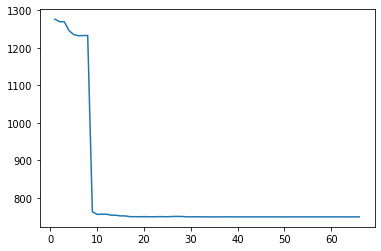

In [60]:
plt.plot(list(range(1, len(train_df.columns) - 2)), performance_across_n_comp)

In [61]:
# compare MSE of full model to PCA regression with 63 components
abs(performance_across_n_comp[62] - mean_squared_error(y_test, y_pred))

0.2514346656607813

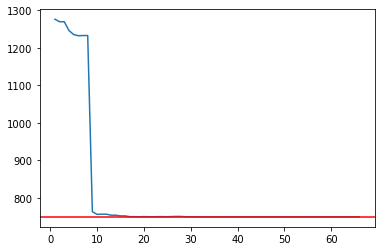

In [62]:
plt.plot(list(range(1, len(train_df.columns) - 2)), performance_across_n_comp)
plt.axhline(y=mean_squared_error(y_test, y_pred), color='r', linestyle='-')